In [ ]:
# Section 1: Install dependencies
!pip install tensorflow keras matplotlib opencv-python

# Section 2: Mount Google Drive and set paths
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Set your dataset base directory here
base_dir = '/content/drive/MyDrive/GlacierDataset/splits'

# Section 3: Load images and masks from the same folder
def load_images_and_masks_from_folder(folder):
    all_files = glob.glob(os.path.join(folder, '*.npy'))
    image_files = [f for f in all_files if 'mask' not in os.path.basename(f).lower()]
    mask_files = [f for f in all_files if 'mask' in os.path.basename(f).lower()]
    image_files.sort()
    mask_files.sort()

    images = [np.load(f) for f in image_files]
    masks = [np.load(f) for f in mask_files]

    return np.array(images), np.array(masks)

# Load train data
train_folder = os.path.join(base_dir, 'train')
X_train, y_train = load_images_and_masks_from_folder(train_folder)

print(f"Loaded training images shape: {X_train.shape}")
print(f"Loaded training masks shape: {y_train.shape}")

Mounted at /content/drive
Loaded training images shape: (383, 512, 512, 15)
Loaded training masks shape: (383, 512, 512, 3)


In [ ]:
def preprocess_masks(masks):
    import tensorflow as tf
    # Combine clean-ice and debris-covered glacier into one glacier class
    glacier_mask = np.logical_or(masks[..., 0], masks[..., 1]).astype(np.uint8)
    one_hot_masks = tf.one_hot(glacier_mask, depth=2)  # Background=0, Glacier=1
    return one_hot_masks

y_train_cat = preprocess_masks(y_train)
print(f"One-hot encoded masks shape: {y_train_cat.shape}")

# Normalize images if needed (assuming images are float32 with values between 0-1)
X_train = X_train[..., [2, 1, 0]]
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_train = X_train.astype('float32')
if X_train.max() > 1.0:
    X_train /= 4095.0  # For 12-bit satellite imagery normalization

One-hot encoded masks shape: (383, 512, 512, 2)


In [ ]:
print(f"X_train min/max: {X_train.min()}, {X_train.max()}")
print(f"y_train_cat min/max: {y_train_cat.numpy().min()}, {y_train_cat.numpy().max()}")
print(f"y_train_cat shape: {y_train_cat.shape}")

X_train min/max: 0.0, 1.0
y_train_cat min/max: 0.0, 1.0
y_train_cat shape: (383, 512, 512, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def dice_loss(y_true, y_pred, smooth=1e-6):
    import tensorflow as tf
    y_true_f = tf.reshape(y_true[...,1], [-1])  # Focus on glacier class
    y_pred_f = tf.reshape(y_pred[...,1], [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def unet_residual_improved(input_shape=(512, 512, 3), num_classes=2):
    from tensorflow.keras import layers, models

    def residual_block(x, filters, kernel_size=3, dropout_rate=0.0):
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x) if x.shape[-1] != filters else x

        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Add()([shortcut, x])
        x = layers.Activation('relu')(x)

        if dropout_rate > 0.0:
            x = layers.Dropout(dropout_rate)(x)
        return x

    def encoder_block(x, filters):
        x = residual_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(x)
        return x, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = residual_block(x, filters)
        return x

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = residual_block(p4, 1024, dropout_rate=0.3)

    # Decoder
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = models.Model(inputs, outputs)
    return model

model = unet_residual_improved(input_shape=(512, 512, 3), num_classes=2)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=dice_loss,
              metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 512, 512,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 512, 512,  │     36,928 │ activation_32[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 512, 512,  │        256 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 512, 512,  │          0 │ conv2d_50[0][0],  │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 512, 512,  │          0 │ add_16[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 256, 256,  │          0 │ activation_33[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 256, 256,  │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 256, 256,  │    147,584 │ activation_34[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │      8,320 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 256, 256,  │          0 │ conv2d_53[0][0],

 Total params: 32,451,138 (123.79 MB)

 Trainable params: 32,439,362 (123.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define exponential decay schedule
def lr_schedule(epoch, lr):
    decay_rate = 0.9
    decay_step = 2
    if epoch % decay_step == 0 and epoch != 0:
        return lr * decay_rate
    return lr

# Define callbacks
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Fit the model
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=2,
    validation_split=0.1,
    callbacks=callbacks
)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 75s 289ms/step - accuracy: 0.6972 - loss: 0.4681 - val_accuracy: 0.7658 - val_loss: 0.9637 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 46s 268ms/step - accuracy: 0.7705 - loss: 0.4160 - val_accuracy: 0.2688 - val_loss: 0.6104 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 8.999999772640876e-05.
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 46s 269ms/step - accuracy: 0.7790 - loss: 0.3793 - val_accuracy: 0.6385 - val_loss: 0.4219 - learning_rate: 9.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.000000136438757e-05.
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 46s 268ms/step - accuracy: 0.8014 - loss: 0.3631 - val_accuracy: 0.7948 - val_loss: 0.8056 - learning_rate: 9.0000e-05

Epoch 5: LearningRateScheduler setting lear

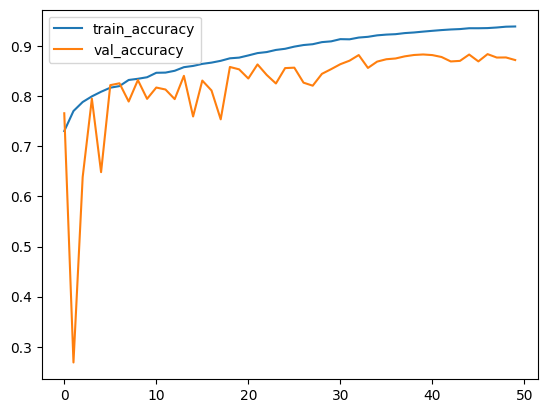

In [ ]:
# Section 7: Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


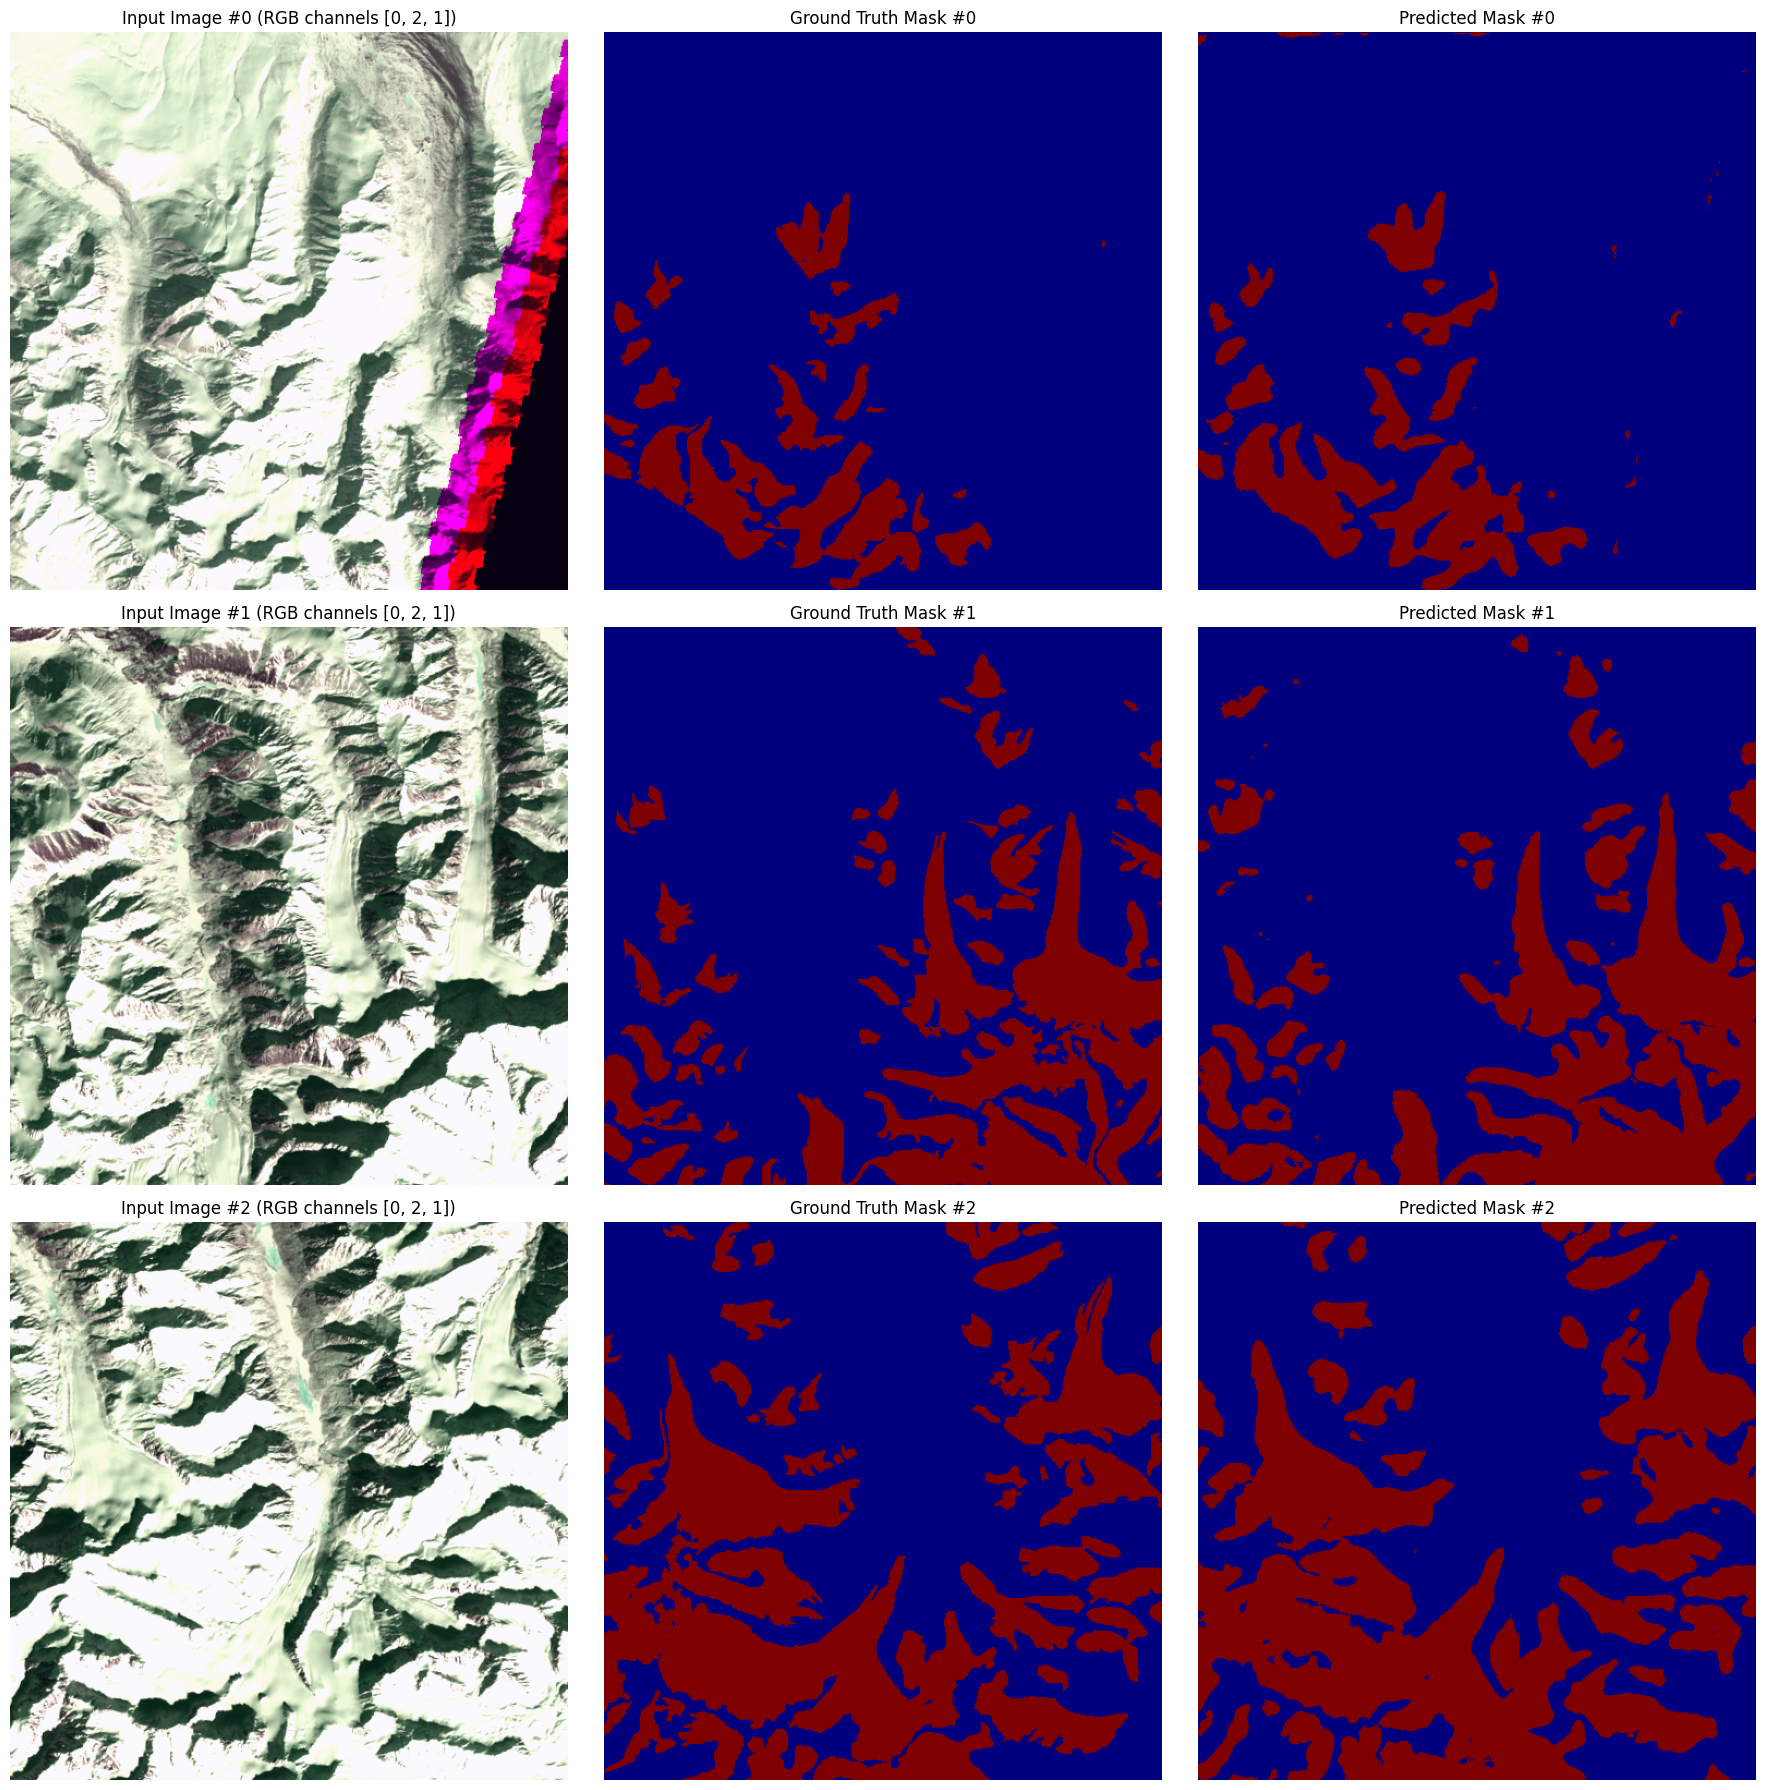

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, X, y_true, indices=[0,1,2], rgb_channels=[3,2,1]):
    """
    Visualize 3 samples:
    - Full-color input image on the left (using specified RGB channels)
    - Ground truth mask in the center
    - Predicted mask on the right

    Parameters:
    - model: trained segmentation model
    - X: input images, shape (N, H, W, C)
    - y_true: one-hot encoded masks, shape (N, H, W, classes)
    - indices: list of 3 indices to visualize
    - rgb_channels: list of channels to use for RGB visualization (default uses channels 3,2,1)
    """
    plt.figure(figsize=(18, 6 * len(indices)))

    for i, idx in enumerate(indices):
        # Prepare input image for display
        img = X[idx]
        # Clip channel indices to valid range
        rgb_ch = [ch if ch < img.shape[2] else 0 for ch in rgb_channels]
        rgb_img = img[:,:,rgb_ch]
        # Normalize for display (0-1)
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-6)

        # Get ground truth mask
        gt_mask = np.argmax(y_true[idx], axis=-1)

        # Predict mask
        pred = model.predict(np.expand_dims(img, axis=0))[0]
        pred_mask = np.argmax(pred, axis=-1)

        # Plot images side by side
        plt.subplot(len(indices), 3, 3*i + 1)
        plt.title(f"Input Image #{idx} (RGB channels {rgb_ch})")
        plt.imshow(rgb_img)
        plt.axis('off')

        plt.subplot(len(indices), 3, 3*i + 2)
        plt.title(f"Ground Truth Mask #{idx}")
        plt.imshow(gt_mask, cmap='jet')
        plt.axis('off')

        plt.subplot(len(indices), 3, 3*i + 3)
        plt.title(f"Predicted Mask #{idx}")
        plt.imshow(pred_mask, cmap='jet')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage: visualize 3 samples from training data
visualize_predictions(model, X_train, y_train_cat, indices=[0,1,2])


In [ ]:
# Save the trained model
model.save('/content/glacier_segmentation_model.h5')